In [43]:
# Import the necessary packages to perform the data analysis

# packages to process and visualize the data
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import json
import folium
#from geopy.geocoders import Nominatim
#from webcolors import rgb_to_name

# packages to improve visual description and analysis
from IPython.core import display as ICD
pd.set_option('display.max_columns', 100)
import os

Import the dataset of top 2000 companies

In [44]:
path='../data/'

In [45]:
#World Bank dataset
GINI_coeff = 'API_SI.POV.GINI_DS2_en_csv_v2_10224868.csv'
ease_of_bus = 'API_IC.BUS.EASE.XQ_DS2_en_csv_v2_10226725.csv'
GDP_tot = 'API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10224782.csv'
GDP_cap = 'API_NY.GDP.PCAP.CD_DS2_en_csv_v2_10224851.csv'
time_start_bus = 'API_IC.REG.DURS_DS2_en_csv_v2_10225592.csv'
time_spent_by_bus = 'API_IC.GOV.DURS.ZS_DS2_en_csv_v2_10230883.csv'
tax_rate = 'API_IC.TAX.TOTL.CP.ZS_DS2_en_csv_v2_10226097.csv'

In [46]:
panama_docs=[]
GDP_docs=[]
for i in os.listdir(path):
    if i[:13]=='panama_papers':
        panama_docs.append(i)
    if i[:10]=='API_NY.GDP':
        GDP_docs.append(i)

In [47]:
df_edges_raw = pd.read_csv(path + panama_docs[0],low_memory=False)
df_address_raw = pd.read_csv(path + panama_docs[1],low_memory=False)
df_entity_raw = pd.read_csv(path + panama_docs[2],low_memory=False)
df_intermediary_raw = pd.read_csv(path + panama_docs[3],low_memory=False)
df_officier_raw = pd.read_csv(path + panama_docs[4],low_memory=False)

In [48]:
df_GDP_tot_raw=pd.read_csv(path + GDP_docs[0],skiprows=4,low_memory=False)
df_GDP_cap_raw=pd.read_csv(path + GDP_docs[1],skiprows=4,low_memory=False)
df_tax_weight=pd.read_csv(path+tax_rate, skiprows=4)
df_ease_business=pd.read_csv(path+ease_of_bus,skiprows=4)
df_gini=pd.read_csv(path+GINI_coeff, skiprows=4)

In [49]:
df_entity_raw

,node_id,name,jurisdiction,jurisdiction_description,country_codes,countries,incorporation_date,inactivation_date,struck_off_date,closed_date,ibcRUC,status,company_type,service_provider,sourceID,valid_until,note
0,10000001,"TIANSHENG INDUSTRY AND TRADING CO., LTD.",SAM,Samoa,HKG,Hong Kong,23-MAR-2006,18-FEB-2013,15-FEB-2013,NaN,25221,Defaulted,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
1,10000002,"NINGBO SUNRISE ENTERPRISES UNITED CO., LTD.",SAM,Samoa,HKG,Hong Kong,27-MAR-2006,27-FEB-2014,15-FEB-2014,NaN,25249,Defaulted,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
2,10000003,"HOTFOCUS CO., LTD.",SAM,Samoa,HKG,Hong Kong,10-JAN-2006,15-FEB-2012,15-FEB-2012,NaN,24138,Defaulted,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
3,10000004,"SKY-BLUE GIFTS & TOYS CO., LTD.",SAM,Samoa,HKG,Hong Kong,06-JAN-2006,16-FEB-2009,15-FEB-2009,NaN,24012,Defaulted,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
4,10000005,FORTUNEMAKER INVESTMENTS CORPORATION,SAM,Samoa,HKG,Hong Kong,19-APR-2006,15-MAY-2009,15-FEB-2008,NaN,R25638,Changed agent,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
5,10000006,8808 HOLDING LIMITED,SAM,Samoa,HKG,Hong Kong,05-JAN-2006,NaN,NaN,NaN,23835,Active,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
6,10000007,KENT DEVELOPMENT LIMITED,SAM,Samoa,HKG,Hong Kong,26-JAN-2004,03-MAY-2006,15-FEB-2006,NaN,15757,Defaulted,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
7,10000008,BONUS TRADE LIMITED,SAM,Samoa,HKG,Hong Kong,13-FEB-2004,16-FEB-2009,15-FEB-2009,NaN,15910,Defaulted,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
8,10000009,AMARANDAN LTD.,SAM,Samoa,HKG,Hong Kong,26-JAN-2004,03-MAY-2006,15-FEB-2006,NaN,15759,Defaulted,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
9,10000010,NEW IDEA LIMITED,SAM,Samoa,HKG,Hong Kong,30-MAR-2004,27-FEB-2007,15-FEB-2007,NaN,16462,Defaulted,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN


**1) Map the tax heavens jurisdiction in terms of the number of entities they have registered**


Here the jurisdiction column of the entity file is considered. It represents the county where the offshore entity is register.

In [50]:
df_entity_raw['jurisdiction_description'].unique()

array(['Samoa', 'Panama', 'Nevada', 'United Kingdom', 'Singapore',
       'Ras Al Khaimah', 'Isle Of Man', 'British Anguilla', 'Seychelles',
       'Niue', 'Uruguay', 'British Virgin Islands', 'Hong Kong',
       'New Zealand', 'Bahamas', 'Cyprus', 'Malta', 'Belize', 'Jersey',
       'Wyoming', 'Costa Rica'], dtype=object)

To better represent all the country present on different graph, all the countries appearing less times than a certain number called here threshold are grouped and considered in following steps as `Others`.

In [51]:
threshold1=1000
df_entity_S1=df_entity_raw.copy()
vc=df_entity_S1.jurisdiction_description.value_counts()
tax_heavens_L=list(vc[vc > threshold1].index)
tax_heavens_S=list(vc[vc <= threshold1].index)
df_entity_S1.loc[~df_entity_S1.jurisdiction_description.isin(tax_heavens_L), 'jurisdiction_description'] = 'Others'
df_entity_S1.jurisdiction_description.value_counts()

British Virgin Islands    113648
Panama                     48360
Bahamas                    15915
Seychelles                 15182
Niue                        9611
Samoa                       5307
British Anguilla            3253
Nevada                      1260
Others                      1098
Name: jurisdiction_description, dtype: int64

A simple histogram is plotted. Logarithmic scale on the $y-axis$ is later applied noticed an approximated exponential distribution. It could be an interesting aspect to investigate. 

Countries in Others category are:  ['Hong Kong', 'United Kingdom', 'Belize', 'Costa Rica', 'Cyprus', 'Uruguay', 'New Zealand', 'Jersey', 'Wyoming', 'Malta', 'Isle Of Man', 'Ras Al Khaimah', 'Singapore']


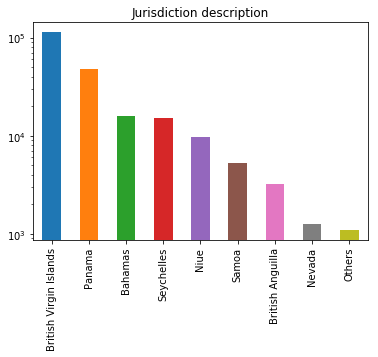

In [52]:
df_entity_S1.jurisdiction_description.value_counts().plot(kind='bar',title='Jurisdiction description', logy=True)
print('Countries in Others category are: ',tax_heavens_S)

A pie chart is also plotted. As mentioned above a heat map of the distribution around the world will be represented.

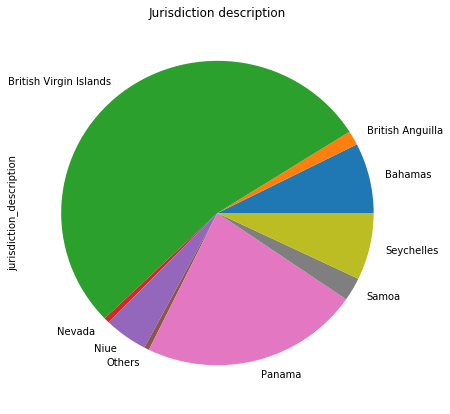

In [53]:
df_entity_S1.jurisdiction_description.value_counts().sort_index().plot(kind='pie', figsize=(7, 7), title='Jurisdiction description')

**2) Map countries in the world according to how much they appear in the Panama Papers in terms of the entities**

The same procedure is applied to the `country` column representing the country of origin of the offshore company. As more country are included a bigger threshold needs to be chosen in order to make the plots still readable. Same as before, the count of companies for country will be represent on a heat map.

In [54]:
df_entity_raw['countries'].unique()

array(['Hong Kong', 'Taiwan', 'China', 'Switzerland', 'Singapore',
       'Brazil', 'Panama', 'Samoa', 'Liechtenstein', 'Spain', 'Thailand',
       'Colombia', 'Jersey', 'Andorra', 'Seychelles', 'Ireland',
       'Belgium', 'Israel', 'Gibraltar', 'Guernsey',
       'United Arab Emirates', 'Cyprus', 'Venezuela', 'Isle of Man',
       'Lebanon', 'Denmark', 'Uruguay', 'Jordan', 'Bahamas',
       'United Kingdom', nan, 'Belize', 'Luxembourg', 'Ecuador',
       'Guatemala', 'Germany', 'Mauritius', 'Turkey', 'United States',
       'Monaco', 'Estonia', 'Niue', 'Czech Republic', 'Netherlands',
       'Hungary', 'Costa Rica', 'Portugal', 'Cayman Islands',
       'South Africa', 'Malta', 'New Zealand', "Côte d'Ivoire",
       'Dominican Republic', 'France', 'Italy', 'Canada', 'Russia',
       'Greece', 'Saudi Arabia', 'Qatar', 'Mexico', 'Peru', 'Bermuda',
       'El Salvador', 'Australia', 'Saint Kitts and Nevis', 'Argentina',
       'Japan', 'Austria', 'American Samoa', 'Paraguay', 'Chile', 'E

In [55]:
threshold2=3000
vc=df_entity_S1.countries.value_counts()
tax_evasions_L=list(vc[vc > threshold2].index)
tax_evasions_S=list(vc[vc <= threshold2].index)
df_entity_S1.loc[~df_entity_S1.countries.isin(tax_evasions_L), 'countries'] = 'Others'
df_entity_S1.countries.value_counts()

Switzerland             37911
Hong Kong               37911
Others                  36495
Panama                  15811
Jersey                  14331
Luxembourg              10840
United Kingdom           9619
Guernsey                 7327
United Arab Emirates     7269
Bahamas                  4984
Uruguay                  4906
Isle of Man              4892
Russia                   4197
Singapore                4081
Cyprus                   3613
China                    3213
Monaco                   3168
United States            3066
Name: countries, dtype: int64

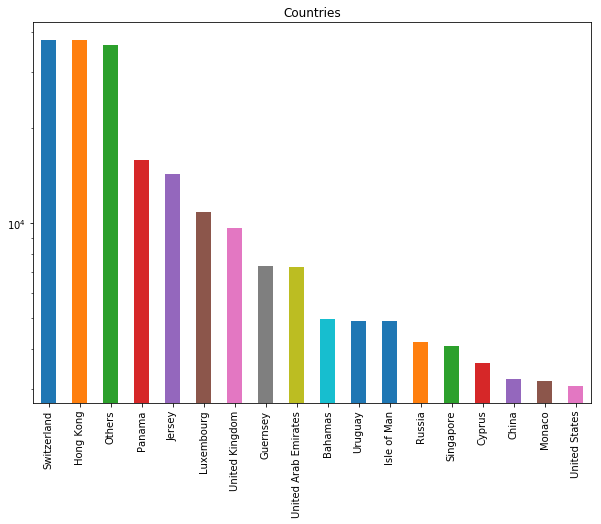

In [56]:
df_entity_S1.countries.value_counts().plot(kind='bar',title='Countries', figsize=(10, 7), logy=True)

The value of the `Others` column is very high indicating a quite heavy tail distribution. As before, plotting the bar chart with a logarithm $y-axis$, seems that the distribution has a exponential behaviour at least his first part. 

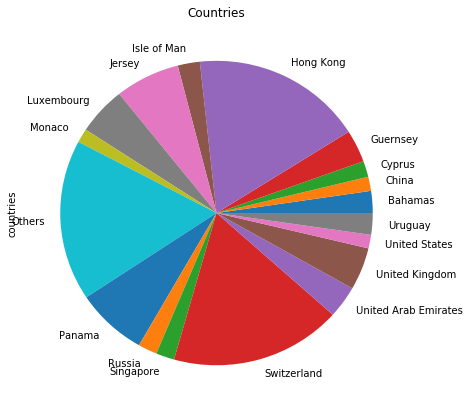

In [57]:
df_entity_S1.countries.value_counts().sort_index().plot(kind='pie', figsize=(7, 7), title='Countries')

An interesting fact can be notice from the distribution of the countries. The majority of the entities present in the papers come from a country with already favourable business condition like Honk Kong, Switzerland and Luxembourg or even from a place considered a fiscal paradise (Panama, Jersey). This fact can be explained with a tendency, amplified by globalization, of big companies of starting their international business already from a convenient economy. Later queries will need to take into account these facts, maybe weighting output by indicator of the economic situation of the county of origin. 
More analysis on this aspect will be performed.


**Plotting distributions on a map**

In [58]:
state_geo_path = path+'countries.geojson'
geo_json_data = json.load(open(state_geo_path))

UnicodeDecodeError: 'ascii' codec can't decode byte 0xc3 in position 8490275: ordinal not in range(128)

In [ ]:
geo_json_data['objects']['cantons']['geometries'][0]

In [ ]:
m_world = folium.Map([0,0], tiles='cartodbpositron', zoom_start=2)
m_world

In [ ]:
folium.TopoJson(geo_json_data,'objects.cantons').add_to(m_world)
m_world

**3)GDP_cap Analysis**

As many of the operation performed with the GDP will involve an inner joint between the latter and the entity data frame, the correctness of the operation is investigated. 

In [ ]:
df_GDP_tot_raw

All the following numbers printed show the condition of the data frame as it is right now, after performing the operation later described. The year with less missing values among the ones that follow the 2008 economic crisis (meaning comparable GDP to the present ones) is chosen as measure of the GDP. It is 2014 with 16 missing values.

In [ ]:
print(df_GDP_tot_raw['2017'].isna().sum())
print(df_GDP_tot_raw['2016'].isna().sum())
print(df_GDP_tot_raw['2015'].isna().sum())
print(df_GDP_tot_raw['2014'].isna().sum())
print(df_GDP_tot_raw['2013'].isna().sum())
print(df_GDP_tot_raw['2012'].isna().sum())

In [ ]:
df_GDP_tot_raw[df_GDP_tot_raw['2014'].isna()]

In [ ]:
df_GDP_tot=df_GDP_tot_raw[['Country Name','2014']].copy()
df_GDP_tot.columns = ['countries', 'GDP_tot']
#df_GDP_tot

A new data frame from the `entity` one is created with only the relevant columns. (value_counts is applied) 

In [ ]:
df_vc=pd.DataFrame(df_entity_raw.countries.value_counts())
df_vc.reset_index(level=0, inplace=True)
df_vc.columns = ['countries', 'n_companies']
#df_vc

Now a merge with an inner join the value counts data frame `df_vc` and the `df_GDP_tot` is performed. All the lines with a missing GDP were visualized below (lines of British Virgin Islands, Turks and Caicos Island, Sint Marteen (dutch part), Monaco, Gibraltar, Cayman Islands, Bermuda and Aruba).  The missing values are manually integrated in the `.csv` looking at reliable data online. The check for nan values now shows an empty dataframe.

In [ ]:
df_GDP_tot_entities=df_vc.merge(df_GDP_tot, how='left',left_on='countries', right_on='countries')
print('Number of countries without GDP in the database: ',df_GDP_tot_entities[df_GDP_tot_entities['GDP_tot'].isna()])
#df_GDP_tot_entities

**3)GDP_tot Analysis**

The same analysis procedure is performed on the GDP pro capita data frame. The same lines of GDP were missing, and they were replaced in the same manner as for the total GDP.

In [ ]:
df_GDP_cap_raw

In [ ]:
print(df_GDP_tot_raw['2017'].isna().sum())
print(df_GDP_tot_raw['2016'].isna().sum())
print(df_GDP_tot_raw['2015'].isna().sum())
print(df_GDP_tot_raw['2014'].isna().sum())
print(df_GDP_tot_raw['2013'].isna().sum())
print(df_GDP_tot_raw['2012'].isna().sum())

In [ ]:
df_GDP_cap=df_GDP_cap_raw[['Country Name','2014']].copy()
df_GDP_cap.columns = ['countries', 'GDP_cap']
#df_GDP_cap

In [ ]:
df_GDP_cap_entities=df_GDP_cap.merge(df_vc, how='inner',left_on='countries', right_on='countries')
print('Number of countries without GDP in the database: ',df_GDP_cap_entities[df_GDP_cap_entities['GDP_cap'].isna()])
#df_GDP_cap_entities

**Chechking mean approximation of databases**

In [ ]:
df_tax_weight

In [ ]:
cols=[0]+list(range(-9,-1))
cols
df_tax_weight_short=df_tax_weight.iloc[:,cols].copy()
df_tax_weight_short['mean'] = df_tax_weight_short.iloc[:,range(-8,0)].mean(axis=1,numeric_only=True)
df_tax_weight_short